### 모듈 임포트 및 환경 설정

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import chi2_contingency
from statsmodels.discrete.discrete_model import MNLogit
import warnings

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.dpi"] = 200

### 데이터 로드
- 05: 22년도
- 04: 21년도
- 03: 20년도
- 02: 19년도

#### 변수 정의

In [3]:
y_cols = ['emp0510', 'emp0410', 'emp0310', 'emp0210'] # 종속 변수
nonresponse_cols = ['nonresponse05', 'nonresponse04_A', 'nonresponse03', 'nonresponse02'] # 미응답 변수
demo_cols = ['pid', 'gender', # 성별
             'age054', 'age044', 'age034', 'age024', # 연령대
             'A05002002', 'A04002002', 'A03002002', 'A02002002', # 배우자 유무
             'A05005002', 'A04005002', 'A03005002', 'A02005002', # 자격증 개수
             'disa056', 'disa046', 'disa036', 'disa026']  # 장해 등급

self_efficacy_cols = []
for a in ['02', '03', '04', '05']:
    for b in range(1, 24):
        col = f'G{a}0230{str(b).zfill(2)}'
        self_efficacy_cols.append(col)

cur_ability_cols = ['B02026001', 'B03026001', 'B04026001', 'B05026001']     
social_cols = ['G05024001', 'G05024002', 'G05024003', 'G04024001', 'G04024002', 'G04024003', 'G03024001', 'G03024002', 'G03024003', 'G02024001', 'G02024002', 'G02024003']
accident_impact_cols = ['G05019001', 'G04019001', 'G03019001', 'G02019001']
phy_social_cols = self_efficacy_cols + cur_ability_cols + social_cols + accident_impact_cols

workplace_cols = ['con16', 'C01011001', 'B01013001', 'C01005001']

cols = y_cols + nonresponse_cols + demo_cols + phy_social_cols + workplace_cols

In [4]:
df = pd.read_csv('pswci2_05_wide.csv', usecols = cols,encoding='cp949')

### 데이터 전처리

#### 4개년도 중 하나라도 미응답자 제거

In [5]:
# non_res_cols 값이 모두 결측인 경우만 필터링하고 non_res_cols 컬럼 제거

non_res_cond = df[nonresponse_cols].notnull().sum(axis = 1) == 0
df = df.loc[non_res_cond].drop(nonresponse_cols, axis = 1)

#### 종속변수정의

In [6]:
df['y_05'] = df['emp0510'].replace({11:2, 12:2, 21:1, 22:1, 31:0, 33:0, 41:0, 44:0, 55:0, 66:0})
df['y_04'] = df['emp0410'].replace({11:2, 12:2, 21:1, 22:1, 31:0, 33:0, 41:0, 44:0, 55:0, 66:0})
df['y_03'] = df['emp0310'].replace({11:2, 12:2, 21:1, 22:1, 31:0, 33:0, 41:0, 44:0, 55:0, 66:0})
df['y_02'] = df['emp0210'].replace({11:2, 12:2, 21:1, 22:1, 31:0, 33:0, 41:0, 44:0, 55:0, 66:0})

In [7]:
df = df.drop(['emp0510', 'emp0410', 'emp0310', 'emp0210'], axis = 1)

#### 연령대정의

In [8]:
# 컬럼명을 단순화함
df = df.rename({"age054":"age_05",
                "age044":"age_04",
                "age034":"age_03",
                "age024":"age_02"}, axis = 1)

#### 배우자 유무 정의

In [9]:
df['spouse_05'] = df['A05002002'].replace({1:0, 2:1, 3:0, 4:0, 5:0})
df['spouse_04'] = df['A04002002'].replace({1:0, 2:1, 3:0, 4:0, 5:0})
df['spouse_03'] = df['A03002002'].replace({1:0, 2:1, 3:0, 4:0, 5:0})
df['spouse_02'] = df['A02002002'].replace({1:0, 2:1, 3:0, 4:0, 5:0})

In [10]:
df = df.drop(['A05002002', 'A04002002', 'A03002002', 'A02002002'], axis = 1)

#### 자격증 개수 정의

In [11]:
df[['A05005002', 'A04005002', 'A03005002', 'A02005002']] = df[['A05005002', 'A04005002', 'A03005002', 'A02005002']].fillna(0)

In [12]:
df = df.rename({"A05005002":"num_certi_05",
                "A04005002":"num_certi_04",
                "A03005002":"num_certi_03",
                "A02005002":"num_certi_02"}, axis = 1)

#### 장해등급 정의

In [13]:
df['disa_05'] = df['disa056'].replace({6:0, 5:1, 4:2, 3:3, 2:4, 1:5})
df['disa_04'] = df['disa046'].replace({6:0, 5:1, 4:2, 3:3, 2:4, 1:5})
df['disa_03'] = df['disa036'].replace({6:0, 5:1, 4:2, 3:3, 2:4, 1:5})
df['disa_02'] = df['disa026'].replace({6:0, 5:1, 4:2, 3:3, 2:4, 1:5})

df = df.drop(['disa056', 'disa046', 'disa036', 'disa026'], axis = 1)

#### 자기 효능감 정의

In [14]:
# 자기효능감 문항이 5로 갈수록 긍정적인 경우도 있지만, 5로 갈수록 부정적인 경우도 있어서 통일시킴
# 긍정 문항 예시: G**023001 (자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다)
# 부정 문항 예시: G**023002 (자신의 행동에 대한 생각-나는 일을 해야 할 때 바로 일을 시작하지 못하는 문제점이 있다)

negative_cols = [2, 5, 6, 7, 10, 12, 14, 16, 17, 18, 20, 22]

In [15]:
for a in ['02', '03', '04', '05']:
    for b in negative_cols:
        df[f'G{a}0230{str(b).zfill(2)}'] = 6 - df[f'G{a}0230{str(b).zfill(2)}']

In [16]:
df['self_effi_02'] = df[[col for col in self_efficacy_cols if col.startswith("G02")]].mean(axis = 1)
df['self_effi_03'] = df[[col for col in self_efficacy_cols if col.startswith("G03")]].mean(axis = 1)
df['self_effi_04'] = df[[col for col in self_efficacy_cols if col.startswith("G04")]].mean(axis = 1)
df['self_effi_05'] = df[[col for col in self_efficacy_cols if col.startswith("G05")]].mean(axis = 1)

In [17]:
df = df.drop(self_efficacy_cols, axis = 1)

#### 현재 업무 능력 정의

In [18]:
df['cur_ability_02'] = df['B02026001']
df['cur_ability_03'] = df['B03026001']
df['cur_ability_04'] = df['B04026001']
df['cur_ability_05'] = df['B05026001']

In [19]:
df = df.drop(cur_ability_cols, axis = 1)

#### 산재 영향 정의

In [20]:
df['accident_impact_05'] = 6 - df['G05019001']
df['accident_impact_04'] = 6 - df['G04019001']
df['accident_impact_03'] = 6 - df['G03019001']
df['accident_impact_02'] = 6 - df['G02019001']

In [21]:
df = df.drop(accident_impact_cols, axis = 1)

#### 사회적 교류 정의

In [22]:
df['social_05'] = df[['G05024001', 'G05024002', 'G05024003']].mean(axis = 1)
df['social_04'] = df[['G04024001', 'G04024002', 'G04024003']].mean(axis = 1)
df['social_03'] = df[['G03024001', 'G03024002', 'G03024003']].mean(axis = 1)
df['social_02'] = df[['G02024001', 'G02024002', 'G02024003']].mean(axis = 1)

In [23]:
df = df.drop(social_cols, axis = 1)

#### 요양 기간 정의

In [24]:
df = df.rename({"con16":"treat_period"}, axis = 1)

#### 노동조합 유무 정의

In [25]:
df['union'] = df['C01011001'].replace({3:0, 2:0})
df = df.drop('C01011001', axis = 1)

#### 관계유지 여부 정의

In [26]:
df = df.rename({"B01013001":"connection"}, axis = 1)

#### 종사상 지위 정의

In [27]:
df['status'] = df['C01005001'].replace({1:0, 2:1, 3:1, 4:0}) # 4는 자영업자인데 논문에서는 처리 방법이 나오지 않아 비정규직으로 간주함
df = df.drop('C01005001', axis = 1)

#### 상호작용항 정의

In [28]:
# 장해등급 x 종사상 지위 (비정규직 여부)
df['Int1_02'] = df['disa_02'] * (1-df['status'])
df['Int1_03'] = df['disa_03'] * (1-df['status'])
df['Int1_04'] = df['disa_04'] * (1-df['status'])
df['Int1_05'] = df['disa_05'] * (1-df['status'])

In [29]:
# 요양기간 x 종사상 지위 (비정규직 여부)
df['Int2'] = df['treat_period'] * (1-df['status'])

#### 공통 요인 세분화

In [30]:
common_cols = [col for col in df.columns if not(col.endswith("_02") or col.endswith("_03") or col.endswith("_04") or col.endswith("_05"))]

In [31]:
for col in common_cols:
    df[col + "_02"] = df[col]
    df[col + "_03"] = df[col]
    df[col + "_04"] = df[col]
    df[col + "_05"] = df[col]    

df = df.drop(common_cols, axis = 1)    

#### 데이터 분할

In [32]:
cols_02 = sorted([col for col in df.columns if col.endswith("_02")])
cols_03 = sorted([col for col in df.columns if col.endswith("_03")])
cols_04 = sorted([col for col in df.columns if col.endswith("_04")])
cols_05 = sorted([col for col in df.columns if col.endswith("_05")])

In [33]:
df_02 = df[cols_02]
df_03 = df[cols_03]
df_04 = df[cols_04]
df_05 = df[cols_05]

In [34]:
# 컬럼명 통일
new_cols = [col[:-3] for col in df_02.columns]
df_02.columns = new_cols
df_03.columns = new_cols
df_04.columns = new_cols
df_05.columns = new_cols

In [35]:
# 데이터 행 단위 병합
df_02['order'] = "1차"
df_03['order'] = "2차"
df_04['order'] = "3차"
df_05['order'] = "4차"
df = pd.concat([df_02, df_03, df_04, df_05], axis = 0, ignore_index = True)

In [36]:
df

,Int1,Int2,accident_impact,age,connection,cur_ability,disa,gender,num_certi,pid,self_effi,social,spouse,status,treat_period,union,y,order
0,5.0,6,5.0,2.0,1,6.0,5.0,1,1.0,2,2.782609,2.333333,0.0,0,6,0.0,0.0,1차
1,5.0,6,5.0,1.0,2,0.0,5.0,1,0.0,3,3.173913,3.000000,1.0,0,6,0.0,1.0,1차
2,5.0,6,5.0,1.0,1,0.0,5.0,1,0.0,4,2.347826,1.333333,0.0,0,6,0.0,0.0,1차
3,5.0,6,5.0,1.0,2,0.0,5.0,1,0.0,5,3.043478,1.000000,0.0,0,6,0.0,0.0,1차
4,0.0,0,5.0,1.0,1,1.0,5.0,1,0.0,6,1.173913,2.000000,0.0,1,6,0.0,0.0,1차
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10287,0.0,0,4.0,4.0,1,2.0,0.0,2,0.0,3290,2.652174,3.000000,0.0,1,2,0.0,0.0,4차
10288,0.0,1,3.0,4.0,1,9.0,0.0,2,0.0,3291,3.869565,3.000000,0.0,0,1,0.0,2.0,4차
10289,0.0,2,5.0,4.0,1,1.0,0.0,2,1.0,3292,3.260870,3.000000,1.0,0,2,0.0,0.0,4차
10290,0.0,0,3.0,4.0,2,8.0,0.0,2,0.0,3293,3.434783,3.000000,0.0,1,3,0.0,1.0,4차


### 데이터 분석

#### 산재근로자의 일반적 특성 (표 4)

In [151]:
gender_freq = pd.concat([df_05['gender'].value_counts().sort_index(), 
                         df_05['gender'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

gender_freq.columns = ["변수", "값", "빈도", "퍼센트"]
gender_freq['퍼센트'] = (gender_freq["퍼센트"] * 100).round(1)

gender_freq['변수'] = '성별'
gender_freq['값'] = gender_freq['값'].replace({1:"남자", 2:"여자"})
gender_freq

,변수,값,빈도,퍼센트
0,성별,남자,2107,81.9
1,성별,여자,466,18.1


In [152]:
age_freq = pd.concat([df_05['age'].value_counts().sort_index(), 
                      df_05['age'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

age_freq.columns = ["변수", "값", "빈도", "퍼센트"]
age_freq['퍼센트'] = (age_freq["퍼센트"] * 100).round(1)

age_freq['변수'] = '연령대'
age_freq['값'] = age_freq['값'].replace({1:"30대 이하", 2:"40대", 3:"50대", 4:"60대 이상"})
age_freq

,변수,값,빈도,퍼센트
0,연령대,30대 이하,238,9.2
1,연령대,40대,378,14.7
2,연령대,50대,695,27.0
3,연령대,60대 이상,1262,49.0


In [153]:
spouse_freq = pd.concat([df_05['spouse'].value_counts().sort_index(), 
                      df_05['spouse'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

spouse_freq.columns = ["변수", "값", "빈도", "퍼센트"]
spouse_freq['퍼센트'] = (spouse_freq["퍼센트"] * 100).round(1)

spouse_freq['변수'] = '배우자'
spouse_freq['값'] = spouse_freq['값'].replace({1:"있음", 0:"없음"})
spouse_freq

,변수,값,빈도,퍼센트
0,배우자,없음,832,32.3
1,배우자,있음,1741,67.7


In [154]:
disa_freq = pd.concat([df_05['disa'].value_counts().sort_index(), 
                      df_05['disa'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

disa_freq.columns = ["변수", "값", "빈도", "퍼센트"]
disa_freq['퍼센트'] = (disa_freq["퍼센트"] * 100).round(1)

disa_freq['변수'] = '장해등급'
disa_freq['값'] = disa_freq['값'].replace({0: "무장해", 1:"13~14급", 2:"10~12급", 3:"8~9급", 4:"4~7급", 5:"1~3급"})
disa_freq

,변수,값,빈도,퍼센트
0,장해등급,무장해,477,18.5
1,장해등급,13~14급,823,32.0
2,장해등급,10~12급,719,27.9
3,장해등급,8~9급,275,10.7
4,장해등급,4~7급,217,8.4
5,장해등급,1~3급,62,2.4


In [155]:
treat_period_freq = pd.concat([df_05['treat_period'].value_counts().sort_index(), 
                      df_05['treat_period'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

treat_period_freq.columns = ["변수", "값", "빈도", "퍼센트"]
treat_period_freq['퍼센트'] = (treat_period_freq["퍼센트"] * 100).round(1)

treat_period_freq['변수'] = '요양 기간'
treat_period_freq['값'] = treat_period_freq['값'].replace({1: "3개월 이하", 2: "3개월 초과 ~ 6개월 이하", 3: "6개월 초과 ~ 9개월 이하", 4: "9개월 초과 ~ 1년 이하", 5: "1년 초과 ~ 2년 이하", 6: "2년 초과"})
treat_period_freq

,변수,값,빈도,퍼센트
0,요양 기간,3개월 이하,461,17.9
1,요양 기간,3개월 초과 ~ 6개월 이하,953,37.0
2,요양 기간,6개월 초과 ~ 9개월 이하,576,22.4
3,요양 기간,9개월 초과 ~ 1년 이하,190,7.4
4,요양 기간,1년 초과 ~ 2년 이하,245,9.5
5,요양 기간,2년 초과,148,5.8


In [156]:
status_freq = pd.concat([df_05['status'].value_counts().sort_index(), 
                      df_05['status'].value_counts(normalize = True).sort_index()], axis = 1).reset_index().reset_index()

status_freq.columns = ["변수", "값", "빈도", "퍼센트"]
status_freq['퍼센트'] = (status_freq["퍼센트"] * 100).round(1)

status_freq['변수'] = '종사상 지위'
status_freq['값'] = status_freq['값'].replace({1: "정규직", 0: "비정규직"})
status_freq

,변수,값,빈도,퍼센트
0,종사상 지위,비정규직,1494,58.1
1,종사상 지위,정규직,1079,41.9


In [157]:
table_4 = pd.concat([gender_freq, age_freq, spouse_freq, disa_freq, treat_period_freq, status_freq], axis = 0, ignore_index = True)
table_4

,변수,값,빈도,퍼센트
0,성별,남자,2107,81.9
1,성별,여자,466,18.1
2,연령대,30대 이하,238,9.2
3,연령대,40대,378,14.7
4,연령대,50대,695,27.0
5,연령대,60대 이상,1262,49.0
6,배우자,없음,832,32.3
7,배우자,있음,1741,67.7
8,장해등급,무장해,477,18.5
9,장해등급,13~14급,823,32.0


#### 종사상 지위에 따른 심리적 변화와 직업복귀

In [158]:
df['status_re'] = df['status'].replace({0:"비정규직", 1:"정규직"})

In [159]:
grouped_mean = df.groupby(['status_re', 'order'])['self_effi'].mean().sort_index(ascending = False).unstack().round(2)
grouped_std = df.groupby(['status_re', 'order'])['self_effi'].std().sort_index(ascending = False).unstack().round(2)
grouped_self_effi = grouped_mean.astype(str) + '(' + grouped_std.astype(str) + ')'

In [160]:
grouped_mean = df.groupby(['status_re', 'order'])['cur_ability'].mean().sort_index(ascending = False).unstack().round(2)
grouped_std = df.groupby(['status_re', 'order'])['cur_ability'].std().sort_index(ascending = False).unstack().round(2)
grouped_cur_ability = grouped_mean.astype(str) + '(' + grouped_std.astype(str) + ')'

In [161]:
grouped_mean = df.groupby(['status_re', 'order'])['social'].mean().sort_index(ascending = False).unstack().round(2)
grouped_std = df.groupby(['status_re', 'order'])['social'].std().sort_index(ascending = False).unstack().round(2)
grouped_social = grouped_mean.astype(str) + '(' + grouped_std.astype(str) + ')'

In [162]:
grouped_self_effi['구분'] = "자기효능감"
grouped_cur_ability['구분'] = "업무수행능력"
grouped_social['구분'] = "사회적 교류"

In [163]:
table_5 = pd.concat([grouped_self_effi, grouped_cur_ability, grouped_social])[['구분', '1차', '2차', '3차', '4차']]
table_5

order,구분,1차,2차,3차,4차
status_re,,,,,
비정규직,자기효능감,3.41(0.5),3.41(0.5),3.44(0.52),3.43(0.51)
정규직,자기효능감,3.32(0.49),3.3(0.5),3.3(0.53),3.3(0.54)
비정규직,업무수행능력,6.77(2.3),7.02(2.25),7.1(2.24),7.16(2.27)
정규직,업무수행능력,6.16(2.32),6.39(2.37),6.44(2.36),6.43(2.4)
비정규직,사회적 교류,2.91(0.4),2.9(0.39),2.88(0.41),2.89(0.4)
정규직,사회적 교류,2.86(0.44),2.86(0.44),2.84(0.46),2.85(0.43)


#### 재해 당시 종사상 지위에 따른 직업복귀 경로

In [164]:
df['y_re'] = df['y'].replace({0:"미취업", 1:"재취업", 2:"원직장 복귀"})

In [175]:
temp = df.groupby(['status_re', 'order', 'y_re'])['pid'].count()
temp = temp.reset_index()
temp1 = temp.loc[temp['status_re'] == "정규직"].pivot(index = "order", columns = "y_re", values = "pid") / 4316 * 100
temp2 = temp.loc[temp['status_re'] == "비정규직"].pivot(index = "order", columns = "y_re", values = "pid") / 5976 * 100

In [176]:
df[df['status_re']=='비정규직']

,Int1,Int2,accident_impact,age,connection,cur_ability,disa,gender,num_certi,pid,self_effi,social,spouse,status,treat_period,union,y,order,status_re,y_re
0,5.0,6,5.0,2.0,1,6.0,5.0,1,1.0,2,2.782609,2.333333,0.0,0,6,0.0,0.0,1차,비정규직,미취업
1,5.0,6,5.0,1.0,2,0.0,5.0,1,0.0,3,3.173913,3.000000,1.0,0,6,0.0,1.0,1차,비정규직,재취업
2,5.0,6,5.0,1.0,1,0.0,5.0,1,0.0,4,2.347826,1.333333,0.0,0,6,0.0,0.0,1차,비정규직,미취업
3,5.0,6,5.0,1.0,2,0.0,5.0,1,0.0,5,3.043478,1.000000,0.0,0,6,0.0,0.0,1차,비정규직,미취업
5,5.0,6,5.0,2.0,1,2.0,5.0,1,0.0,7,3.434783,2.000000,1.0,0,6,1.0,0.0,1차,비정규직,미취업
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10283,0.0,2,5.0,4.0,2,6.0,0.0,2,0.0,3286,2.869565,3.000000,0.0,0,2,0.0,0.0,4차,비정규직,미취업
10285,0.0,1,2.0,4.0,1,7.0,0.0,2,0.0,3288,3.043478,3.000000,1.0,0,1,0.0,0.0,4차,비정규직,미취업
10286,0.0,2,2.0,4.0,1,6.0,0.0,2,0.0,3289,3.347826,3.000000,1.0,0,2,0.0,0.0,4차,비정규직,미취업
10288,0.0,1,3.0,4.0,1,9.0,0.0,2,0.0,3291,3.869565,3.000000,0.0,0,1,0.0,2.0,4차,비정규직,원직장 복귀


In [177]:
temp2

y_re,미취업,원직장 복귀,재취업
order,,,
1차,7.580321,9.638554,7.781124
2차,7.914993,8.333333,8.751673
3차,7.747657,7.831325,9.421017
4차,8.115797,7.161981,9.722222


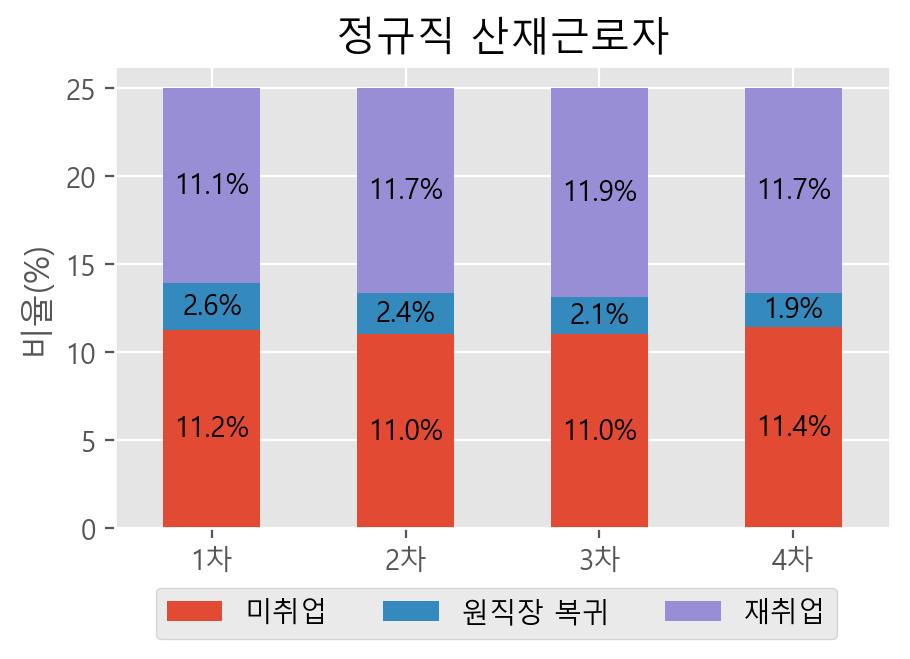

In [178]:
ax = temp1.plot(kind='bar', stacked=True, figsize=(5, 3), rot=0, xlabel='', ylabel='비율(%)', title = "정규직 산재근로자")
for c in ax.containers:
    labels = [str(round(v.get_height(), 1)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(bbox_to_anchor=(0.95, -0.1), ncol= 3)

In [170]:
temp2

y_re,미취업,원직장 복귀,재취업
order,,,
1차,41.983318,53.382762,43.095459
2차,43.836886,46.153846,48.470806
3차,42.910102,43.373494,52.177943
4차,44.949027,39.666358,53.846154


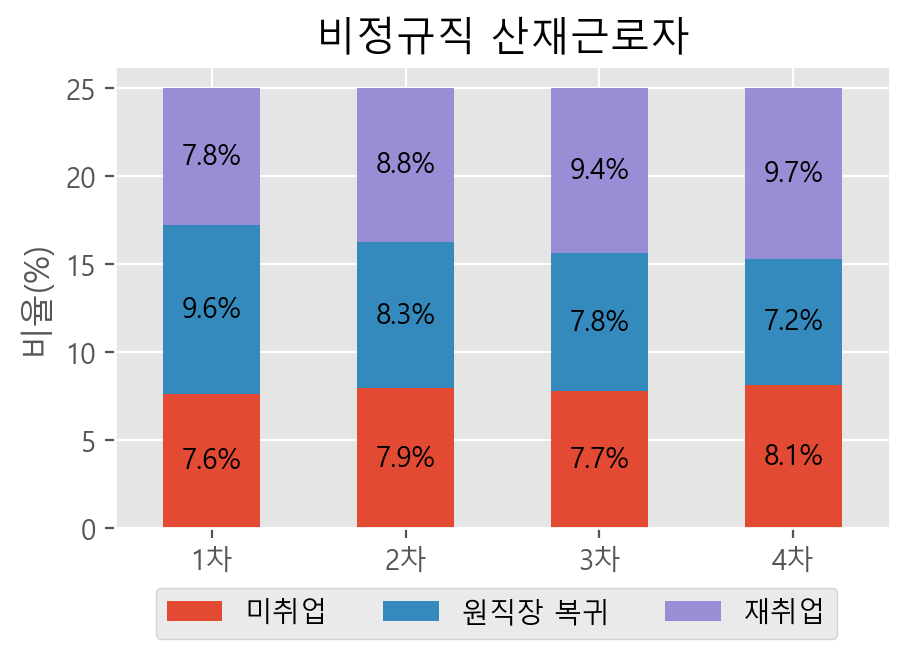

In [179]:
ax = temp2.plot(kind='bar', stacked=True, figsize=(5, 3), rot=0, xlabel='', ylabel='비율(%)', title = "비정규직 산재근로자")
for c in ax.containers:
    labels = [str(round(v.get_height(), 1)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(bbox_to_anchor=(0.95, -0.1), ncol= 3)

#### 카이제곱 독립성 검정 결과

In [53]:
temp1 = temp.loc[temp['order'] == "1차"].pivot(index = "status_re", columns = "y_re", values = "pid")
temp2 = temp.loc[temp['order'] == "2차"].pivot(index = "status_re", columns = "y_re", values = "pid")
temp3 = temp.loc[temp['order'] == "3차"].pivot(index = "status_re", columns = "y_re", values = "pid")
temp4 = temp.loc[temp['order'] == "4차"].pivot(index = "status_re", columns = "y_re", values = "pid")

In [54]:
temp1['조사연도'] = '1차'
temp2['조사연도'] = '2차'
temp3['조사연도'] = '3차'
temp4['조사연도'] = '4차'

In [55]:
temp1['총합'] = temp1[['원직장 복귀', '재취업', '미취업']].sum(axis = 1)
temp2['총합'] = temp2[['원직장 복귀', '재취업', '미취업']].sum(axis = 1)
temp3['총합'] = temp3[['원직장 복귀', '재취업', '미취업']].sum(axis = 1)
temp4['총합'] = temp4[['원직장 복귀', '재취업', '미취업']].sum(axis = 1)

In [56]:
temp1 = temp1.reset_index().rename({"status_re":"구분"}, axis = 1)[['조사연도', '구분', '총합', '원직장 복귀', '재취업', '미취업']]
temp2 = temp2.reset_index().rename({"status_re":"구분"}, axis = 1)[['조사연도', '구분', '총합', '원직장 복귀', '재취업', '미취업']]
temp3 = temp3.reset_index().rename({"status_re":"구분"}, axis = 1)[['조사연도', '구분', '총합', '원직장 복귀', '재취업', '미취업']]
temp4 = temp4.reset_index().rename({"status_re":"구분"}, axis = 1)[['조사연도', '구분', '총합', '원직장 복귀', '재취업', '미취업']]

In [57]:
stat, pval = chi2_contingency(temp1[['원직장 복귀', '재취업', '미취업']])[:2]
stat = round(stat, 4)
pval = round(pval, 4)
chi_result = f"{stat}({pval})"
temp1['카이제곱검정결과'] = chi_result

In [58]:
stat, pval = chi2_contingency(temp2[['원직장 복귀', '재취업', '미취업']])[:2]
stat = round(stat, 4)
pval = round(pval, 4)
chi_result = f"{stat}({pval})"
temp2['카이제곱검정결과'] = chi_result

In [59]:
stat, pval = chi2_contingency(temp3[['원직장 복귀', '재취업', '미취업']])[:2]
stat = round(stat, 4)
pval = round(pval, 4)
chi_result = f"{stat}({pval})"
temp3['카이제곱검정결과'] = chi_result

In [60]:
stat, pval = chi2_contingency(temp4[['원직장 복귀', '재취업', '미취업']])[:2]
stat = round(stat, 4)
pval = round(pval, 4)
chi_result = f"{stat}({pval})"
temp4['카이제곱검정결과'] = chi_result

In [61]:
table_6 = pd.concat([temp1, temp2, temp3, temp4], axis = 0, ignore_index = True)

In [62]:
table_6 # [조사연도], [카이제곱검정결과]는 한 셀로 병합 가능

y_re,조사연도,구분,총합,원직장 복귀,재취업,미취업,카이제곱검정결과
0,1차,비정규직,1494,576,465,453,250.2434(0.0)
1,1차,정규직,1079,114,480,485,250.2434(0.0)
2,2차,비정규직,1494,498,523,473,200.0188(0.0)
3,2차,정규직,1079,102,503,474,200.0188(0.0)
4,3차,비정규직,1494,468,563,463,192.9949(0.0)
5,3차,정규직,1079,92,513,474,192.9949(0.0)
6,4차,비정규직,1494,428,581,485,177.9613(0.0)
7,4차,정규직,1079,82,504,493,177.9613(0.0)


#### 혼합효과 다항로지스틱 분석

In [63]:
endog1 = df.loc[df['y'].isin([0, 1]), 'y']
endog2 = df.loc[df['y'].isin([0, 2]), 'y']

In [64]:
exog11 = df.loc[df['y'].isin([0, 1]), ["gender", "age", "spouse", "num_certi", "disa"]]
exog12 = df.loc[df['y'].isin([0, 2]), ["gender", "age", "spouse", "num_certi", "disa"]]

In [65]:
res11 = MNLogit(endog1, exog11).fit()
res12 = MNLogit(endog2, exog12).fit()
 
res11 = pd.read_html(res11.summary().tables[1].as_html())[0][['y=1', 'coef', 'P>|z|']]
res12 = pd.read_html(res12.summary().tables[1].as_html())[0][['y=2', 'coef', 'P>|z|']]

res11.columns = ["변수", "B", "p-value"]
res12.columns = ["변수", "B", "p-value"]

res11 = res11.set_index("변수")
res12 = res12.set_index("변수")

res11['exp(B)'] = np.exp(res11["B"])
res12['exp(B)'] = np.exp(res12["B"])

res1 = pd.concat([res11, res12], axis = 1).reset_index()
res1 # 좌측 세 개는 원직장복귀/미취업, 우측 세 개는 재취업/미취업을 나타냄

Optimization terminated successfully.
         Current function value: 0.667040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607738
         Iterations 5


,변수,B,p-value,exp(B),B,p-value,exp(B)
0,gender,0.4212,0.0,1.523789,0.3217,0.0,1.379471
1,age,-0.0971,0.0,0.907465,-0.4064,0.0,0.666044
2,spouse,0.2114,0.0,1.235406,0.9935,0.0,2.700670
3,num_certi,0.2236,0.0,1.250571,0.1581,0.0,1.171283
4,disa,-0.2567,0.0,0.773600,-0.2701,0.0,0.763303


In [66]:
exog21 = df.loc[df['y'].isin([0, 1]), ["self_effi", "cur_ability", "accident_impact", "social"]]
exog22 = df.loc[df['y'].isin([0, 2]), ["self_effi", "cur_ability", "accident_impact", "social"]]

In [67]:
res21 = MNLogit(endog1, exog11).fit()
res22 = MNLogit(endog2, exog12).fit()
 
res21 = pd.read_html(res21.summary().tables[1].as_html())[0][['y=1', 'coef', 'P>|z|']]
res22 = pd.read_html(res22.summary().tables[1].as_html())[0][['y=2', 'coef', 'P>|z|']]

res21.columns = ["변수", "B", "p-value"]
res22.columns = ["변수", "B", "p-value"]

res21 = res21.set_index("변수")
res22 = res22.set_index("변수")

res21['exp(B)'] = np.exp(res21["B"])
res22['exp(B)'] = np.exp(res22["B"])

res2 = pd.concat([res21, res22], axis = 1).reset_index()
res2 # 좌측 세 개는 원직장복귀/미취업, 우측 세 개는 재취업/미취업을 나타냄

Optimization terminated successfully.
         Current function value: 0.667040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607738
         Iterations 5


,변수,B,p-value,exp(B),B,p-value,exp(B)
0,gender,0.4212,0.0,1.523789,0.3217,0.0,1.379471
1,age,-0.0971,0.0,0.907465,-0.4064,0.0,0.666044
2,spouse,0.2114,0.0,1.235406,0.9935,0.0,2.700670
3,num_certi,0.2236,0.0,1.250571,0.1581,0.0,1.171283
4,disa,-0.2567,0.0,0.773600,-0.2701,0.0,0.763303


In [68]:
exog31 = df.loc[df['y'].isin([0, 1]), ["treat_period", "union", "connection", "Int1", "Int2"]].dropna() # 노동조합 여부를 모르는 경우는 삭제함
exog32 = df.loc[df['y'].isin([0, 2]), ["treat_period", "union", "connection", "Int1", "Int2"]].dropna()

In [69]:
endog1 = df.loc[(df['y'].isin([0, 1])) & (df['union'].notnull()), 'y']
endog2 = df.loc[(df['y'].isin([0, 2])) & (df['union'].notnull()), 'y']

In [70]:
res31 = MNLogit(endog1, exog31).fit()
res32 = MNLogit(endog2, exog32).fit()
 
res31 = pd.read_html(res31.summary().tables[1].as_html())[0][['y=1', 'coef', 'P>|z|']]
res32 = pd.read_html(res32.summary().tables[1].as_html())[0][['y=2', 'coef', 'P>|z|']]

res31.columns = ["변수", "B", "p-value"]
res32.columns = ["변수", "B", "p-value"]

res31 = res31.set_index("변수")
res32 = res32.set_index("변수")

res31['exp(B)'] = np.exp(res31["B"])
res32['exp(B)'] = np.exp(res32["B"])

res2 = pd.concat([res31, res32], axis = 1).reset_index()
res2 # 좌측 세 개는 원직장복귀/미취업, 우측 세 개는 재취업/미취업을 나타냄

Optimization terminated successfully.
         Current function value: 0.666638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565515
         Iterations 6


,변수,B,p-value,exp(B),B,p-value,exp(B)
0,treat_period,-0.3027,0.0,0.738821,-0.5424,0.000,0.581351
1,union,-0.4756,0.0,0.621512,1.4327,0.000,4.189997
2,connection,0.5172,0.0,1.677325,-0.1078,0.008,0.897807
3,Int1,-0.1817,0.0,0.833851,-0.1131,0.001,0.893061
4,Int2,0.2125,0.0,1.236766,0.5303,0.000,1.699442


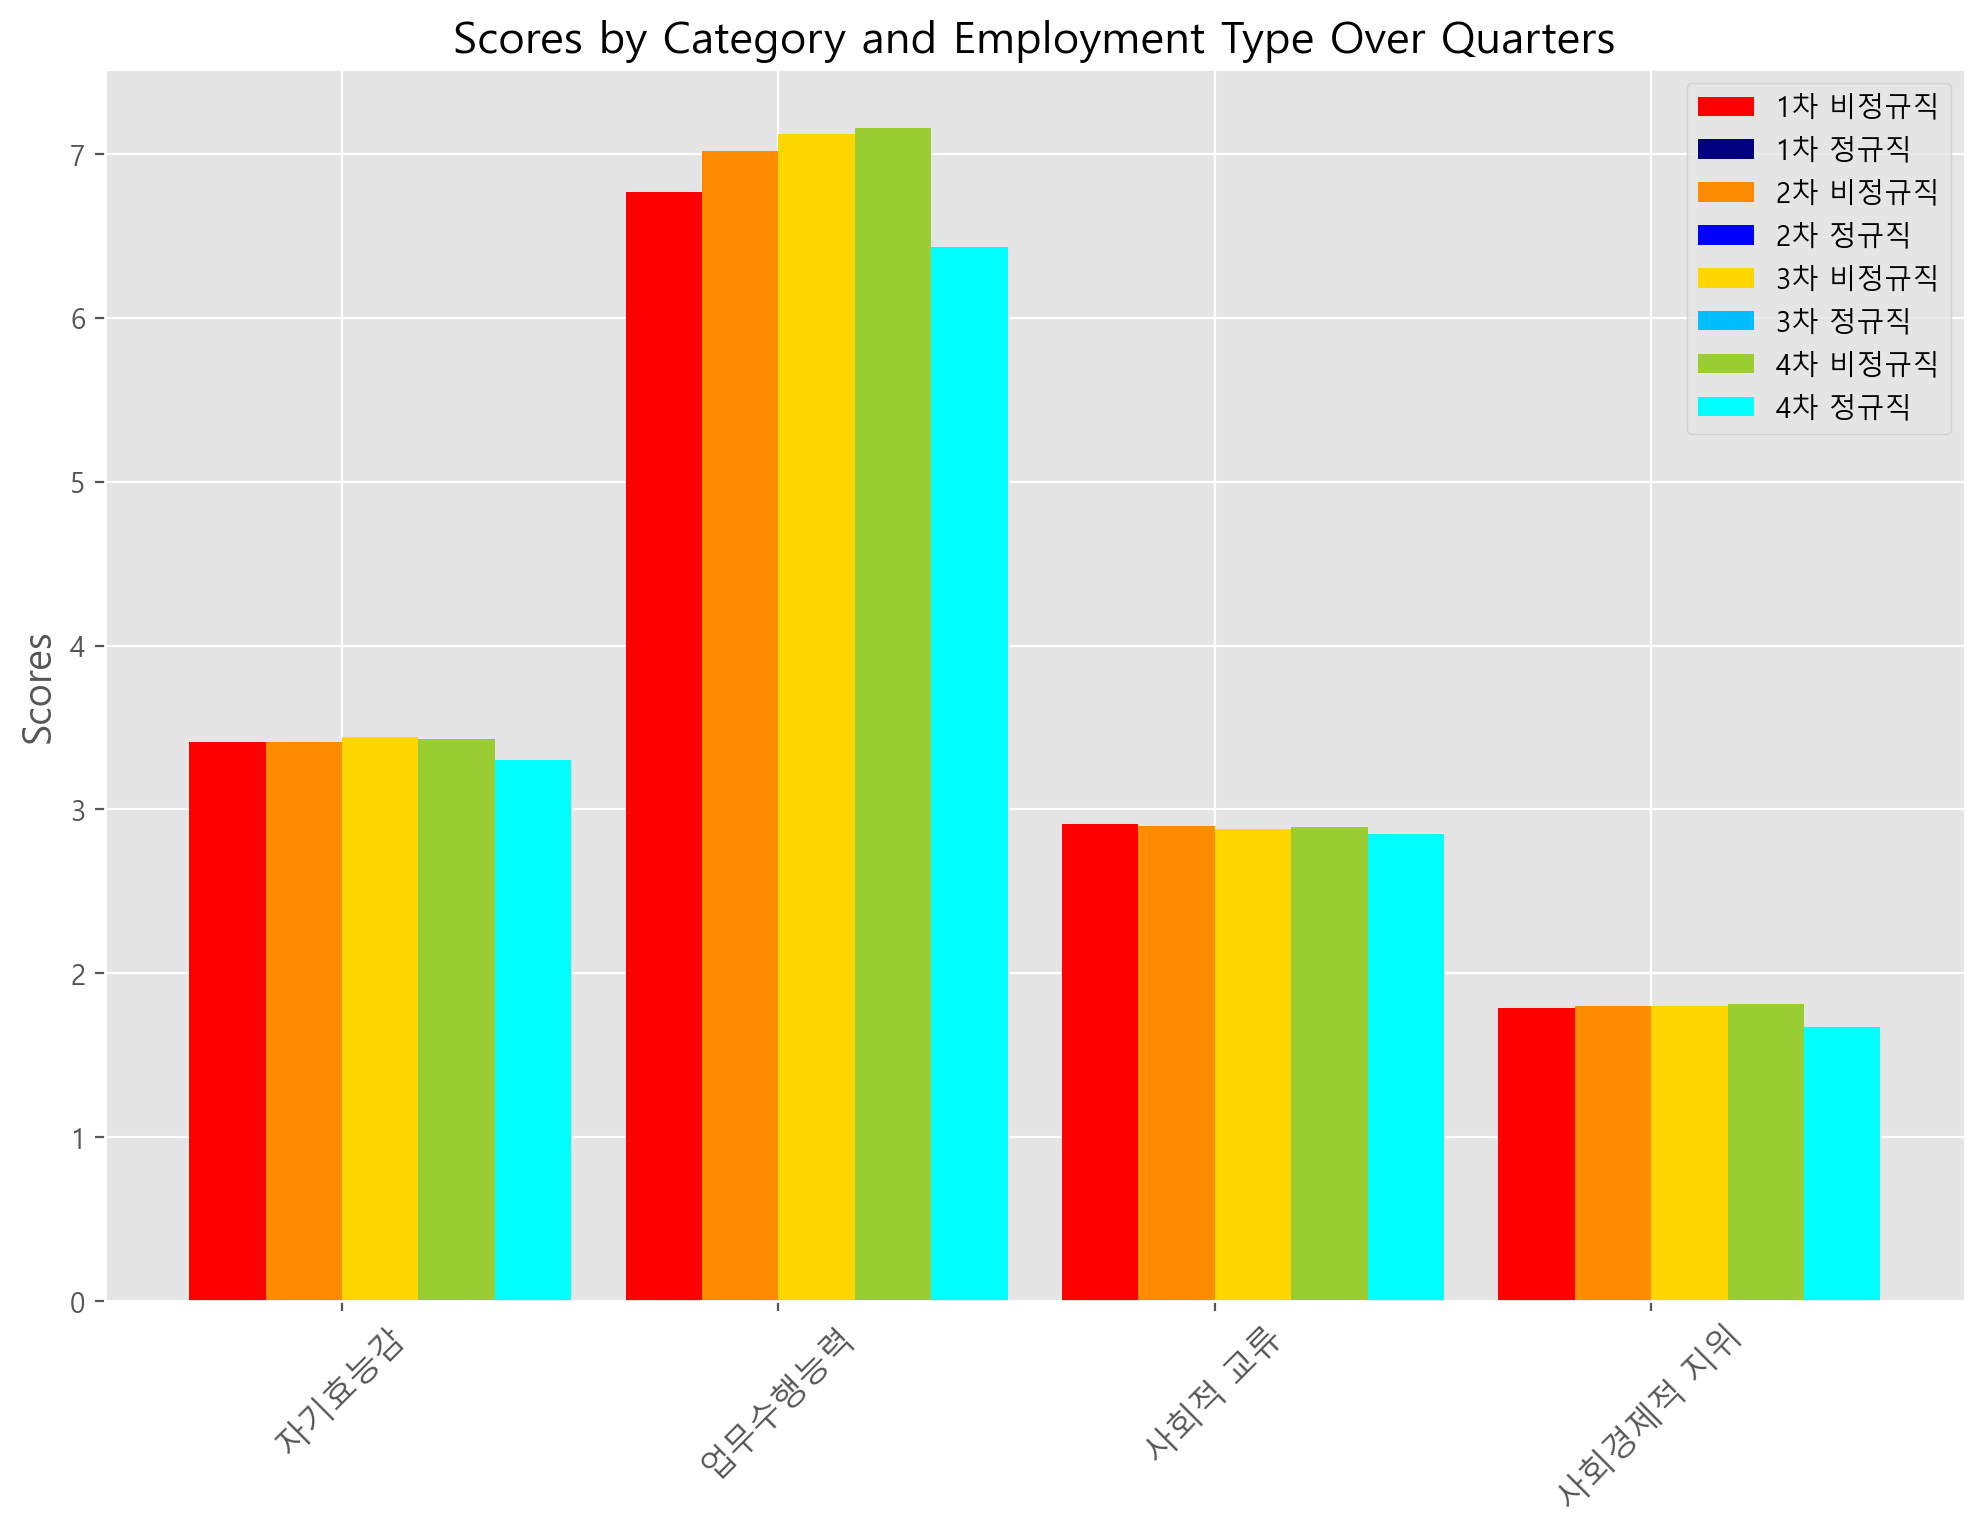

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'Category': [
        '자기효능감', '자기효능감', 
        '업무수행능력', '업무수행능력', 
        '사회적 교류', '사회적 교류', 
        '사회경제적 지위', '사회경제적 지위'
    ],
    'Type': ['비정규직', '정규직']*4,
    '1차': [3.41, 3.32, 6.77, 6.16, 2.91, 2.86, 1.79, 1.57],
    '2차': [3.41, 3.30, 7.02, 6.39, 2.90, 2.86, 1.80, 1.61],
    '3차': [3.44, 3.30, 7.12, 6.44, 2.88, 2.84, 1.80, 1.63],
    '4차': [3.43, 3.30, 7.16, 6.43, 2.89, 2.85, 1.81, 1.67]
}
df = pd.DataFrame(data)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.35  # Bar width

# Define colors for better distinction
colors_non_regular = ['red', 'darkorange', 'gold', 'yellowgreen']
colors_regular = ['navy', 'blue', 'deepskyblue', 'cyan']

# Generate bars for each quarter by category
for i, quarter in enumerate(['1차', '2차', '3차', '4차']):
    offsets = np.arange(len(df) // 2) * 2 + width * i
    ax.bar(offsets, df[df['Type'] == '비정규직'][quarter], width=width, color=colors_non_regular[i], label=f'{quarter} 비정규직')
    ax.bar(offsets + width, df[df['Type'] == '정규직'][quarter], width=width, color=colors_regular[i], label=f'{quarter} 정규직')

# Customize the chart
ax.set_xticks(np.arange(len(df) // 2) * 2 + width * 1.5)
ax.set_xticklabels(df['Category'].unique(), fontsize=12)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Scores by Category and Employment Type Over Quarters', fontsize=16)
ax.legend()

plt.xticks(rotation=45)  # Rotate category names for better visibility
plt.show()

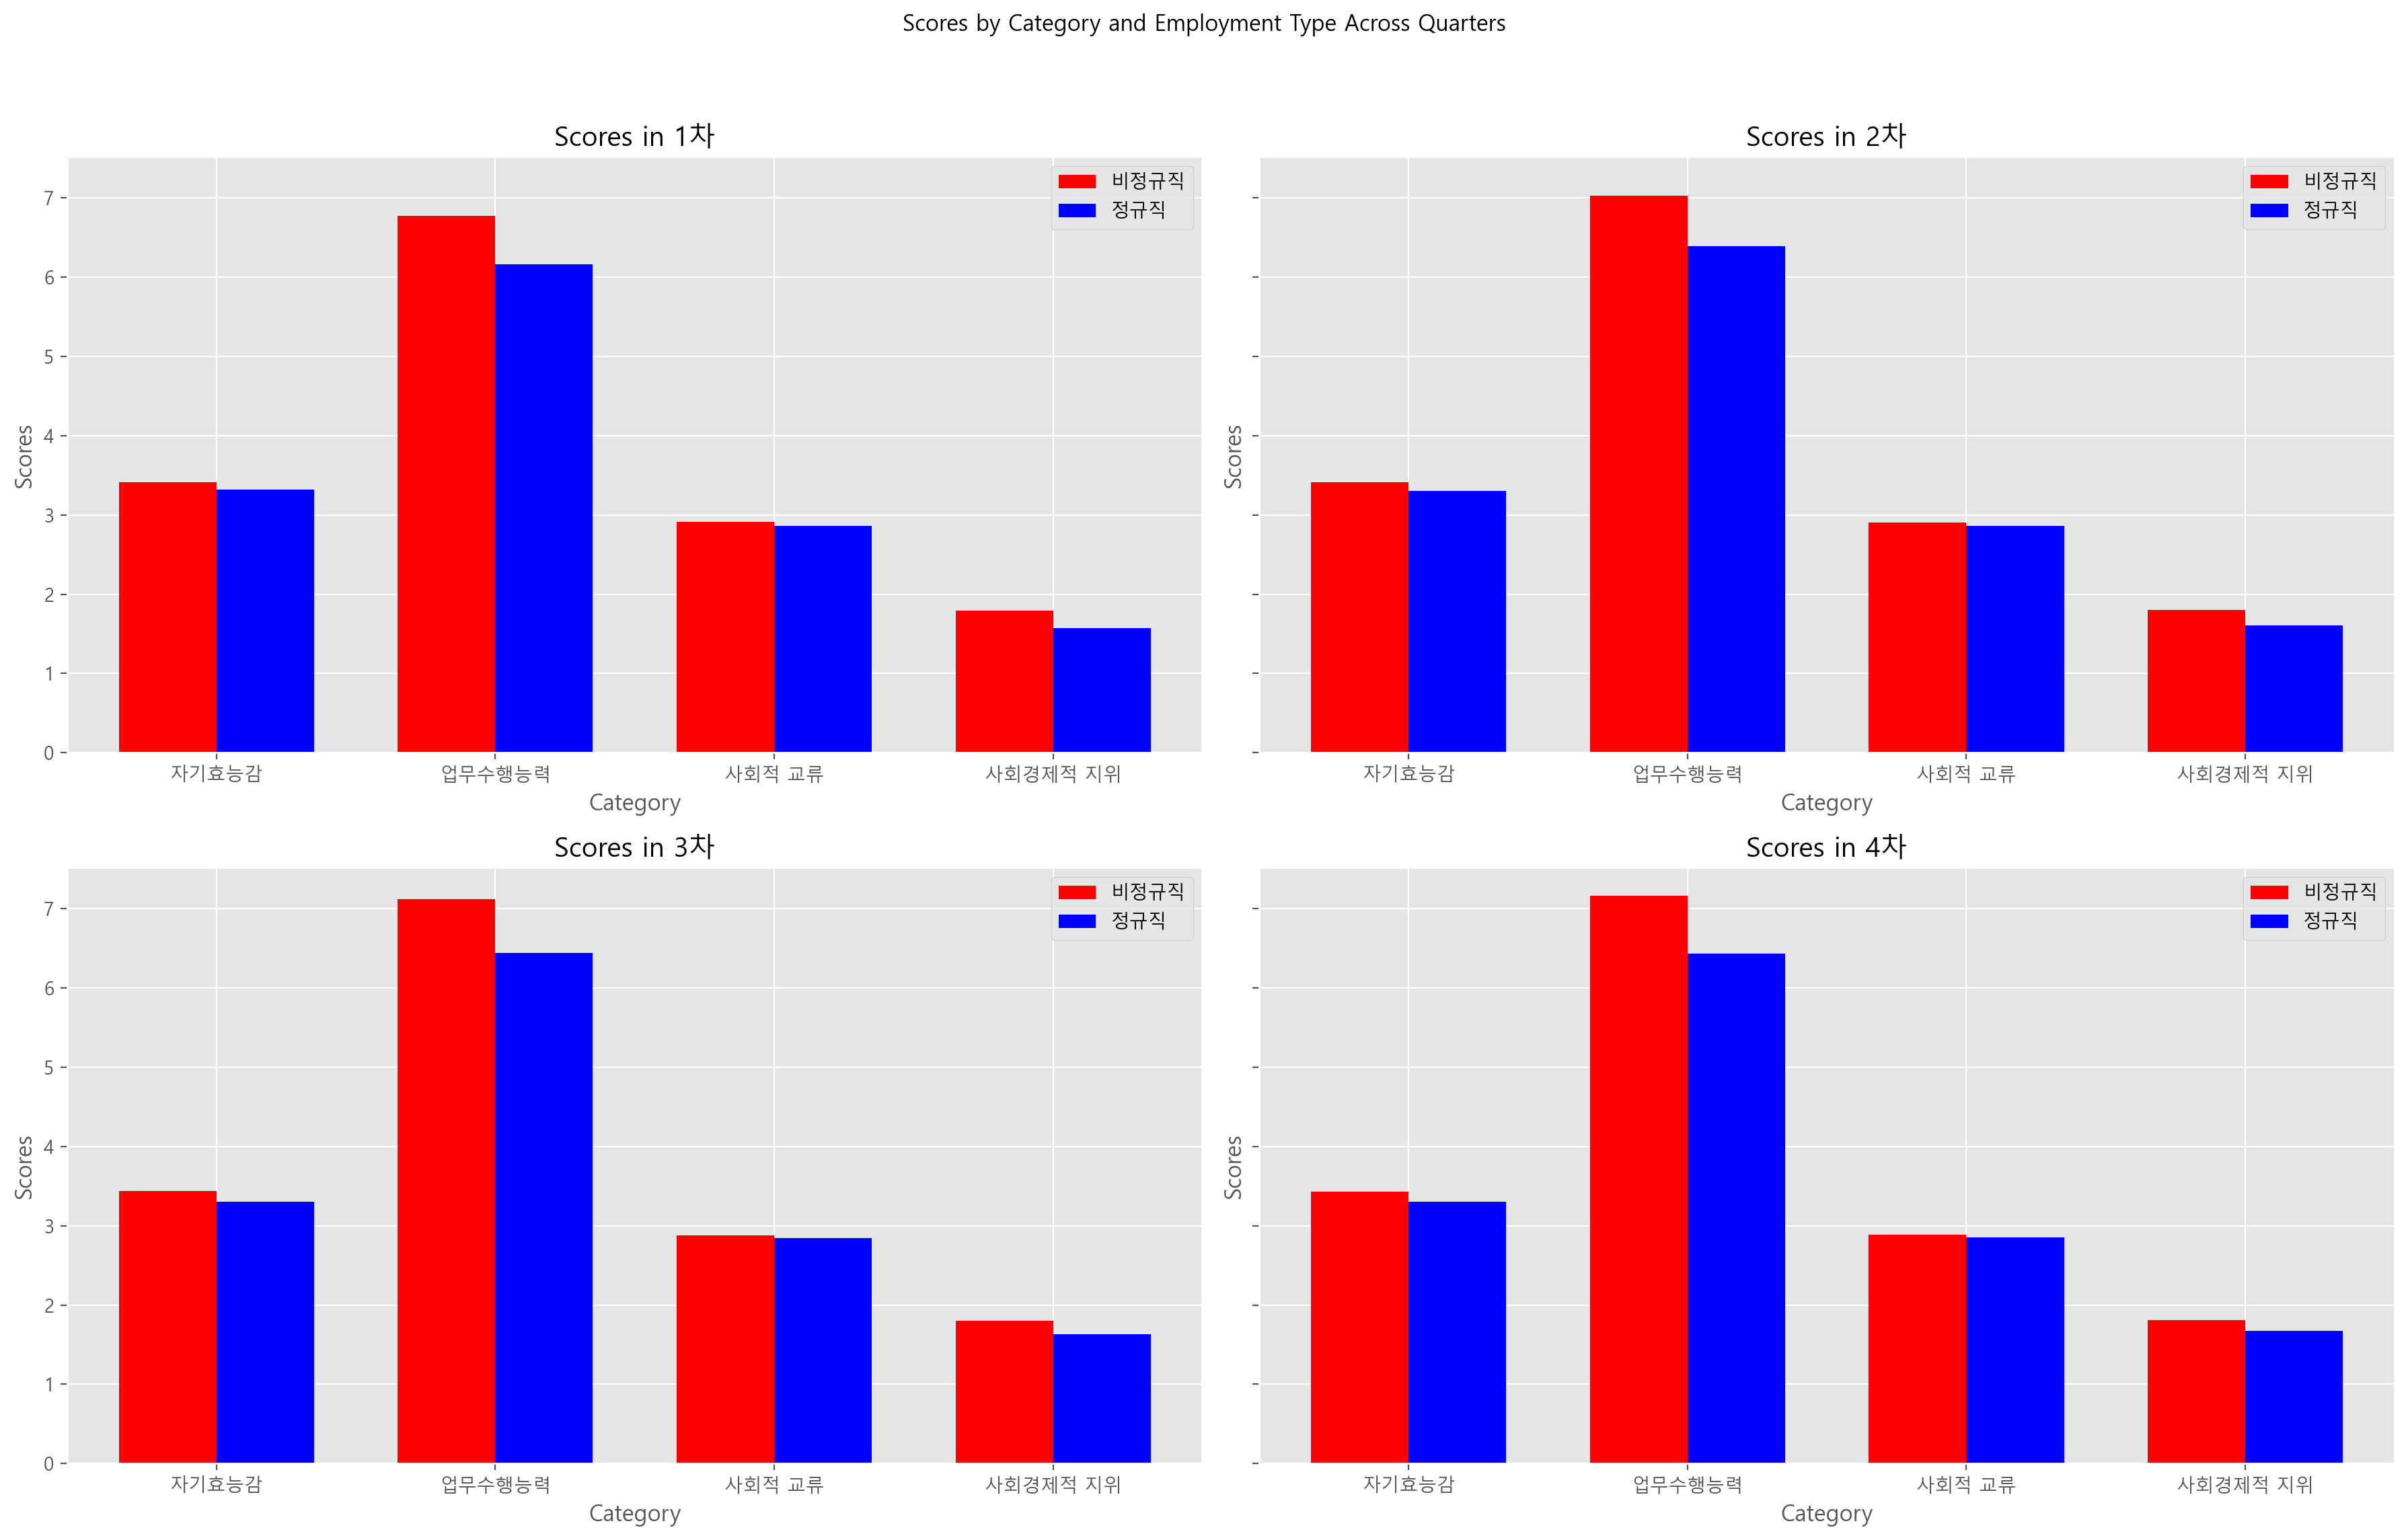

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'Category': [
        '자기효능감', '자기효능감', 
        '업무수행능력', '업무수행능력', 
        '사회적 교류', '사회적 교류', 
        '사회경제적 지위', '사회경제적 지위'
    ],
    'Type': ['비정규직', '정규직']*4,
    '1차': [3.41, 3.32, 6.77, 6.16, 2.91, 2.86, 1.79, 1.57],
    '2차': [3.41, 3.30, 7.02, 6.39, 2.90, 2.86, 1.80, 1.61],
    '3차': [3.44, 3.30, 7.12, 6.44, 2.88, 2.84, 1.80, 1.63],
    '4차': [3.43, 3.30, 7.16, 6.43, 2.89, 2.85, 1.81, 1.67]
}
df = pd.DataFrame(data)

# Define colors for better distinction
colors = ['red', 'blue']

# Function to create bar charts for each quarter
def plot_quarter(quarter, ax):
    # Calculate offsets for grouped bars
    categories = df['Category'].unique()
    x = np.arange(len(categories))  # the label locations for categories
    width = 0.35  # the width of the bars

    for i, category in enumerate(categories):
        subset = df[df['Category'] == category]
        ax.bar(x[i] - width/2, subset[subset['Type'] == '비정규직'][quarter].values, width, label='비정규직' if i == 0 else "", color=colors[0])
        ax.bar(x[i] + width/2, subset[subset['Type'] == '정규직'][quarter].values, width, label='정규직' if i == 0 else "", color=colors[1])

    ax.set_xlabel('Category')
    ax.set_ylabel('Scores')
    ax.set_title(f'Scores in {quarter}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
quarters = ['1차', '2차', '3차', '4차']

for i, ax in enumerate(axs.flatten()):
    plot_quarter(quarters[i], ax)

fig.suptitle('Scores by Category and Employment Type Across Quarters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

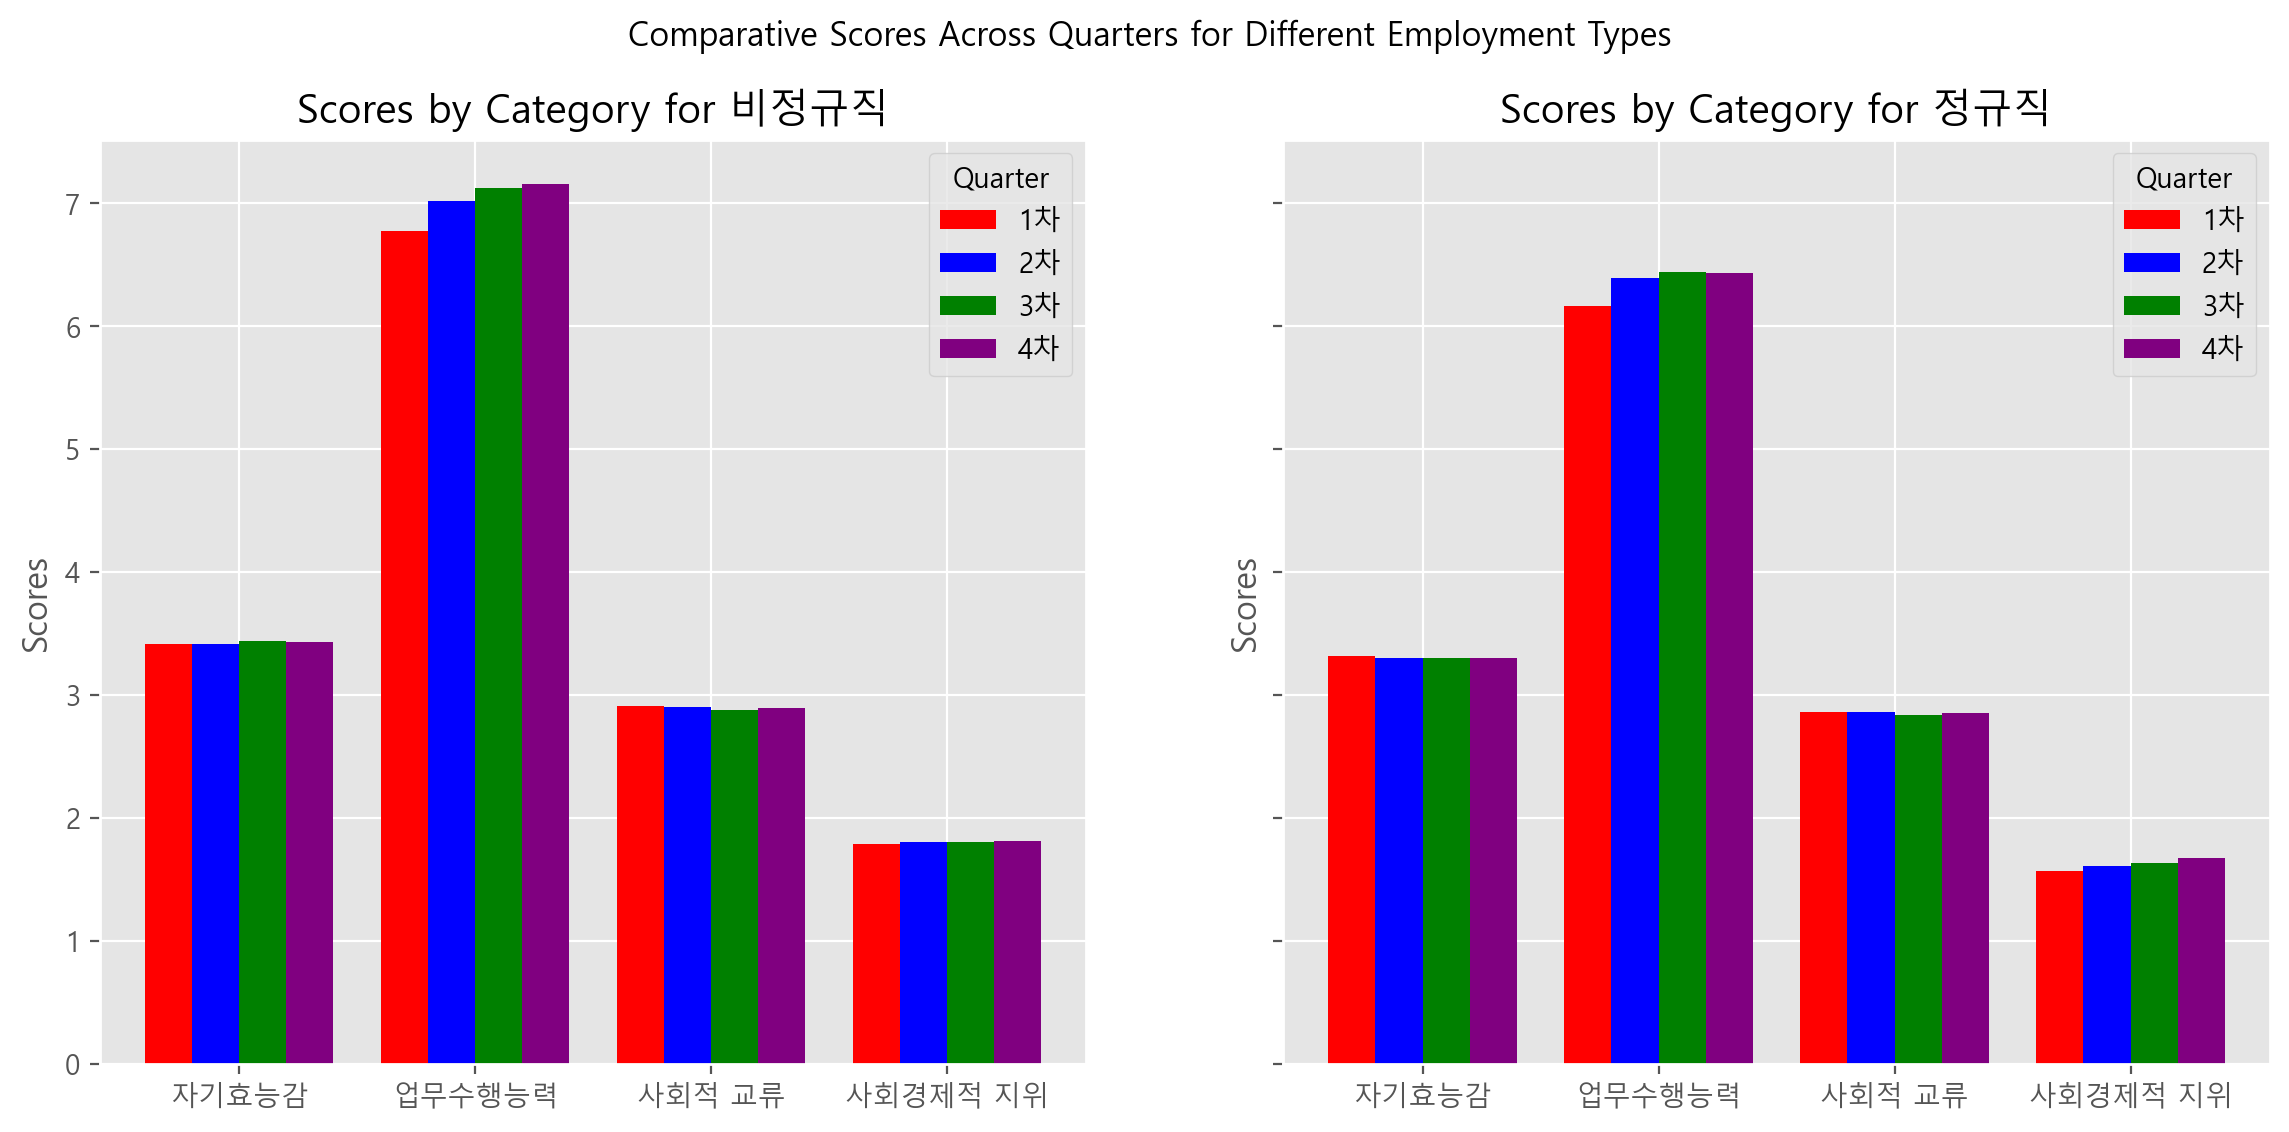

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    'Category': [
        '자기효능감', '자기효능감', 
        '업무수행능력', '업무수행능력', 
        '사회적 교류', '사회적 교류', 
        '사회경제적 지위', '사회경제적 지위'
    ],
    'Type': ['비정규직', '정규직']*4,
    '1차': [3.41, 3.32, 6.77, 6.16, 2.91, 2.86, 1.79, 1.57],
    '2차': [3.41, 3.30, 7.02, 6.39, 2.90, 2.86, 1.80, 1.61],
    '3차': [3.44, 3.30, 7.12, 6.44, 2.88, 2.84, 1.80, 1.63],
    '4차': [3.43, 3.30, 7.16, 6.43, 2.89, 2.85, 1.81, 1.67]
}
df = pd.DataFrame(data)

# Function to plot for a specific type
def plot_for_type(df, type_label, ax):
    width = 0.2  # Width of the bars
    x = np.arange(len(df['Category'].unique()))  # x locations for the groups

    # Plot each quarter
    quarters = ['1차', '2차', '3차', '4차']
    colors = ['red', 'blue', 'green', 'purple']  # Different color for each quarter
    for i, quarter in enumerate(quarters):
        ax.bar(x + i * width, df[(df['Type'] == type_label)][quarter], width, label=f'{quarter}', color=colors[i])

    ax.set_ylabel('Scores')
    ax.set_title(f'Scores by Category for {type_label}')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(df['Category'].unique())
    ax.legend(title='Quarter')

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

plot_for_type(df, '비정규직', ax1)
plot_for_type(df, '정규직', ax2)

plt.suptitle('Comparative Scores Across Quarters for Different Employment Types')
plt.show()